# 使用自编码器进行图像去噪


## 直观理解


### 什么是图像去噪？


图像去噪是指从图像中去除不必要的噪声。这是图像处理中的一项关键任务。
我们的目标是将一张带噪声的图像输入网络，并输出一张干净的图像。

![去噪示例](./images/Denoising.jpg)

图片来源：[论文链接](https://www.researchgate.net/publication/350432472_A_Modified_Heat_Diffusion_Based_Method_for_Enhancing_Physical_Images)。


### 使用自编码器进行图像去噪


要使用自编码器架构完成该任务，只需将一张带噪声的图像（我们生成的）输入解码器，让其重建图像，并将重建后的图像与原始无噪声图像进行比较。

![去噪后的 Lena 图像](./images/DenoisedLena.png)


通过使用这种架构，我们旨在构建一个鲁棒的去噪模型，能够对所有图像进行去噪。为了训练该模型，我们需要一个大型的图像数据集，并确保生成的噪声与现实图像中的噪声类似。


## 使用 PyTorch 中的自编码器进行图像去噪


我们仍然使用 MNIST 数据集。我们将在图像上生成人工噪声，并训练我们的自编码器去除这些噪声，以获得干净的图像。


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### 数据集与数据加载器


In [2]:
transform=T.ToTensor() # Pour convertir les éléments en tensor torch directement
dataset = datasets.MNIST(root='./../data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST(root='./../data', train=False,transform=transform)
train_dataset, validation_dataset=torch.utils.data.random_split(dataset, [0.8,0.2])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader= DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### 噪声生成


我们通过一个示例展示噪声应用，以可视化图像在不同噪声水平下的退化情况。


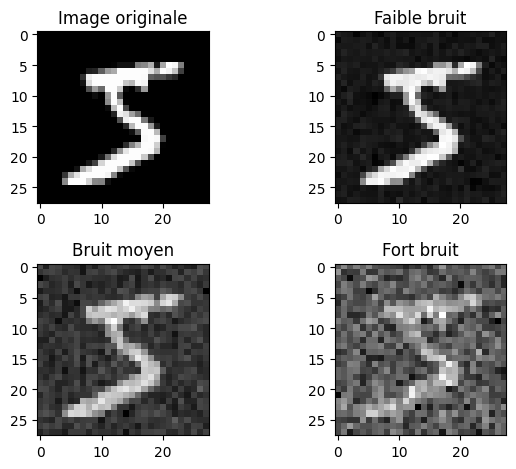

In [3]:
image,_=dataset[0]
# Le paramètre dans le np.sqrt correspond à la variance désirée donc np.sqrt(...) est l'écart type
# torch.randn génére des valeurs aléatoire extraites d'une distribution gaussienne de mean 0 et variance 1
imageNoisy1 = image + np.sqrt(0.001)*torch.randn(1, 28, 28)
imageNoisy2 = image + np.sqrt(0.01)*torch.randn(1, 28, 28)
imageNoisy3 = image + np.sqrt(0.1)*torch.randn(1, 28, 28)

plt.subplot(2, 2, 1)
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title("Image originale")

plt.subplot(2, 2, 2)
plt.imshow(imageNoisy1.squeeze().numpy(), cmap='gray')
plt.title("Faible bruit")

plt.subplot(2, 2, 3)
plt.imshow(imageNoisy2.squeeze().numpy(), cmap='gray')
plt.title("Bruit moyen")

plt.subplot(2, 2, 4)
plt.imshow(imageNoisy3.squeeze().numpy(), cmap='gray')
plt.title("Fort bruit")

plt.tight_layout()
plt.show()

在训练过程中，我们将使用中等水平的噪声。之后，我们可以观察我们的去噪自编码器在其他噪声水平下的表现。


### 构建我们的模型


对于这一复杂任务，我们使用卷积自编码器。


In [4]:
# Nous réutilisons les fonctions introduites dans l'exemple de segmentation du cours 3 
def conv_relu_bn(input_channels, output_channels, kernel_size, stride, padding):
  return nn.Sequential(
    nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding),
    nn.ReLU(),
    nn.BatchNorm2d(output_channels,momentum=0.01)
  )
    
def convT_relu_bn(input_channels, output_channels, kernel_size, stride, padding):
  return nn.Sequential(
    nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
    nn.ReLU(),
    nn.BatchNorm2d(output_channels,momentum=0.01)
  )
    
    
class ae_conv(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)

    self.encoder = nn.Sequential( # Sequential permet de groupe une série de transformation
      conv_relu_bn(1,8,kernel_size=3,stride=2,padding=1),
      conv_relu_bn(8,16,kernel_size=3,stride=2,padding=1),
      conv_relu_bn(16,32,kernel_size=3,stride=1,padding=1),
    )
    self.decoder = nn.Sequential(
      convT_relu_bn(32,16,kernel_size=4,stride=2,padding=1),
      convT_relu_bn(16,8,kernel_size=4,stride=2,padding=1),
      nn.Conv2d(8,1,kernel_size=3,stride=1,padding=1),
      nn.Sigmoid()
    )
  
  def forward(self,x): 
    x = self.encoder(x)
    denoise = self.decoder(x)
    return denoise

In [5]:
model = ae_conv() # Couches d'entrée de taille 2, deux couches cachées de 16 neurones et un neurone de sortie
print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

Nombre de paramètres 16385


### 模型训练


In [6]:
criterion = nn.MSELoss()
epochs=10
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [7]:
for i in range(epochs):
  loss_train=0
  for images, _ in train_loader:
    images=images+np.sqrt(0.01)*torch.randn(images.shape)
    recons=model(images)
    loss=criterion(recons,images)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, _ in val_loader:
    with torch.no_grad():
      images=images+np.sqrt(0.01)*torch.randn(images.shape)
      recons=model(images)
      loss=criterion(recons,images)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.0253756046295166
step 0 val loss 0.010878251865506172
step 1 train loss 0.00976449716836214
step 1 val loss 0.008979358710348606
step 2 train loss 0.00827114749699831
step 2 val loss 0.007526080124080181
step 3 train loss 0.00706455297768116
step 3 val loss 0.0066648973152041435
step 4 train loss 0.006312613375484943
step 4 val loss 0.005955129396170378
step 5 train loss 0.00576859712600708
step 5 val loss 0.005603262223303318
step 6 train loss 0.0055686105042696
step 6 val loss 0.005487256217747927
step 7 train loss 0.0054872902110219
step 7 val loss 0.005444051697850227
step 8 train loss 0.0054359594359993935
step 8 val loss 0.005416598636657
step 9 train loss 0.005397486500442028
step 9 val loss 0.005359680857509375


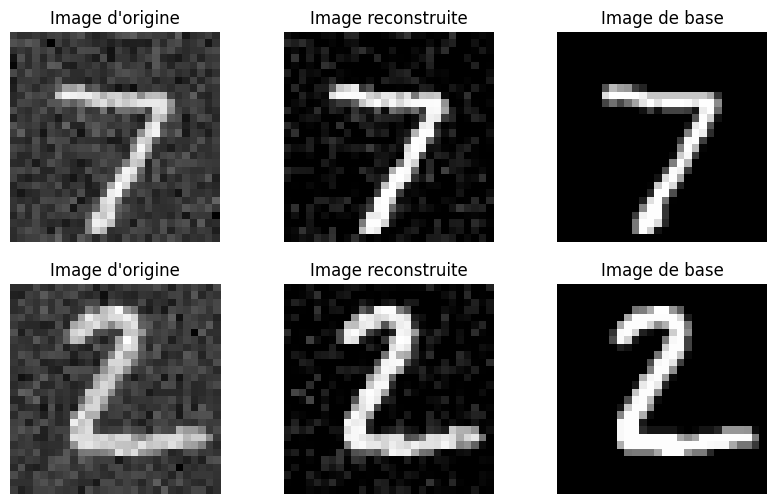

In [8]:
images,_=next(iter(test_loader))
variance=0.01
#Isolons un élément
fig, axs = plt.subplots(2, 3, figsize=(10, 6)) 
for i in range(2):
  image=images[i].unsqueeze(0)
  noisy_image=image+np.sqrt(variance)*torch.randn(image.shape)

  with torch.no_grad():
      recons=model(noisy_image)

  # Image d'origine
  axs[i][0].imshow(noisy_image[0].squeeze().cpu().numpy(), cmap='gray')
  axs[i][0].set_title('Image d\'origine')
  axs[i][0].axis('off')

  # Image reconstruite
  axs[i][1].imshow(recons[0].squeeze().cpu().numpy(), cmap='gray')
  axs[i][1].set_title('Image reconstruite')
  axs[i][1].axis('off')

  axs[i][2].imshow(image[0].squeeze().cpu().numpy(), cmap='gray')
  axs[i][2].set_title('Image de base')
  axs[i][2].axis('off')
plt.show()

我们的去噪结果相当不错，尽管仍存在一些伪影。通过改变方差参数，您可以观察到去噪自编码器在其他噪声水平下的表现。


## 练习


您可以尝试在噪声水平随机（在某些方差值范围内）的图像上训练模型，以观察模型是否能够泛化到该区间内的任何高斯噪声。您可能需要增加模型的复杂度，并增加训练时的 *epoch* 数量。


**U-Net**：您还可以尝试测试 U-Net 架构（见课程 3 中的图像分割部分）进行去噪任务，并将其结果与自编码器进行比较。
